In [1]:
import subprocess
from multiprocessing import Process

from ensemble_train import crps, create_model_from_config, crps_no_avg
import numpy as np
import pandas as pd
import os
import sys
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import summary
from tqdm import tqdm
import yaml
import glob
import copy

sys.path.append('../utils')
import helpers

import matplotlib.pyplot as plt
import matplotlib as mpl


from scipy.stats import norm
%matplotlib inline

# Load Best Config Files

In [ ]:
configs = []
for config_path in glob.glob(os.path.join("experiments/eff_of_hyperparams/best_configs", '*.yaml')):
    print(config_path)

    with open(config_path, 'r') as config_file:
        config = yaml.safe_load(config_file)

    configs.append(config)

# Create Variants

In [ ]:
connectivity = [0,30,50,70,100,200,400,1000]  # only max dist for now
depth = [1,2,3,4]
embedding = [1,2,4,8,16,32,64]
hidden_channels = [16,32,64,128,265,512]

variants = {"connectivity": connectivity,
            "depth":depth,
            "embedding":embedding,
            "hidden_channels": hidden_channels}
variants

In [ ]:
# Create Config Files
variants_configs = {}
for parameter, variants_list in variants.items():
    print(f"Creating configs for Hyperparameter: {parameter}")
    variants_dict = {}
    for variant in variants_list:
        print(f"Values: {variant}")
        conf_variants = []
        for config in configs:
            config_copy = copy.deepcopy(config)
            if parameter == "connectivity":
                config_copy["data"]["method"] = "max_dist"
                config_copy["data"]["max_dist"] = variant
            elif parameter == "depth":
                config_copy["model"]["num_layers"] = variant
            elif parameter == "embedding":
                config_copy["model"]["embed_dim"] = variant
            elif parameter == "hidden_channels":
                config_copy["model"]["hidden_channels"] = variant
            conf_variants.append(config_copy)
        variants_dict[variant] = conf_variants
    variants_configs[parameter] = variants_dict

In [ ]:
scores_dict = {}
for hyperparam, dicts in variants_configs.items():
    folder_path = os.path.join("experiments", "eff_of_hyperparams", hyperparam)
    for value, configs in dicts.items():
        value_folder = os.path.join(folder_path, str(value))
        if not os.path.exists(value_folder):
            os.makedirs(value_folder)
        for config in configs:
            config_path = os.path.join(value_folder, config["model"]["architecture"])
            if not os.path.exists(config_path):
                os.makedirs(config_path)
            config_path_file = config_path + f"/{config['model']['architecture']}_{hyperparam}_{value}.yaml"
            with open(config_path_file, 'w') as file:
                yaml.dump(config, file)
            print(f"created config {config_path_file}")

# Train Ensembles...

In [ ]:
#TODO Train hidden channels 512 GlobalInfo again

In [ ]:
def split_list(input_list, n):
    return [input_list[i:i + n] for i in range(0, len(input_list), n)]

def run_script(params):
    """
    Train a single model by launching a single subprocess facilitating the training
    :param params: tuple containing the id of the run, the device number and the name of the config file for the run
    """
    id_val, device_val, config_val = params
    cmd = [sys.executable, "ensemble_train.py", "--id", str(id_val), "--device", str(device_val), "--config", config_val, "--no-small"]
    print(f"Executing command {cmd}")
    subprocess.run(cmd)

def train_ensemble(config_path, n):
    """
    Trains an ensemble of models
    :param config_path: path to the config file of the models
    :param n: number of models to train in parallel
    """
    params = [(i, idx%2, config_path) for idx, i in enumerate(range(10))]
    params_list_list = split_list(params, n)

    for params_list in params_list_list:
        print(f"Start training of models")
        processes = []
        for params in params_list:
            print(params[0])
            process = Process(target=run_script, args=(params,))
            processes.append(process)
            process.start()

        for process in processes:
            process.join()

In [ ]:
folder_path = "experiments/eff_of_hyperparams/connectivity"

files = glob.glob(os.path.join(folder_path, '**', '*.yaml'), recursive=True)

files.sort(key=lambda x:int(x.split("/")[3]))

In [ ]:
# Start from 400
files = files[19:]
files

In [ ]:
for config in files:
    print(f"training ensemble for {config}")
    train_ensemble(config, 2)

# ...and measure scores

In [8]:
def get_models_from_checkpoints(config_path, config, emb_num_features):
    model_list = []
    for snapshot in os.listdir(f"{os.path.dirname(config_path)}/checkpoints"):
        path_to_snapshot = f"{os.path.dirname(config_path)}/checkpoints/{snapshot}"
        model, optimizer, _ = create_model_from_config(config, emb_num_features, device)
        try:
            checkpoint = torch.load(path_to_snapshot)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.to(device)
            model_list.append(model)
        except Exception as e:
            print(e)
            print(f"could not load {path_to_snapshot}")
    return model_list

def evaluate_ensemble(model_list, loader):
    mu_list_model = []
    sigma_list_model = []

    for model in model_list:
        mu_list_batch = []
        sigma_list_batch = []
        y_list = []

        for batch in loader:
            batch.to(device)
            out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            mu, sigma = torch.split(out, 1, dim=-1)
            y = batch.y
            y = y.cpu().numpy()
            y_list.append(y)

            mu = mu.detach().cpu().numpy().flatten()
            mu_list_batch.append(mu)
            sigma = sigma.detach().cpu().numpy().flatten()
            sigma_list_batch.append(sigma)


        mu = np.concatenate(mu_list_batch)
        mu_list_model.append(mu)
        sigma = np.concatenate(sigma_list_batch)
        sigma_list_model.append(sigma)
        y = np.concatenate(y_list)

    mu = np.array(mu_list_model).T.mean(axis=1).reshape(-1,1)
    sigma = np.array(sigma_list_model).T.mean(axis=1).reshape(-1,1)

    mu = torch.tensor(mu).to(device)
    sigma = torch.tensor(sigma).to(device)
    preds = torch.cat([mu, sigma], dim=1)
    y = torch.tensor(y).to(device)
    err = crps(mu_sigma=preds, y=y)
    print(f"Ensemble CRPS: {err.item()}")
    return err

def create_torch_dataset(normalized_data, dist_matrix, position_matrix, config):
    torch_data_test = []
    pbar = tqdm(normalized_data['date'].unique(), desc="Creating PyG Data", leave=False)
    for date in pbar:
        pbar.set_postfix({"date": date})
        torch_data_test.append(helpers.create_data(df=normalized_data,
                                                   date=date,
                                                   dist_matrix=dist_matrix,
                                                   position_matrix=position_matrix,
                                                   method=config['data']['method'],
                                                   max_dist=config['data']['max_dist'],
                                                   k=config['data']['nearest_k'],
                                                   nearest_k_mode=config['data']['nearest_k_mode']))
    return torch_data_test

In [9]:
# Load Data
data = helpers.load_data(indexed=False)
data = helpers.clean_data(data, max_missing=121, max_alt=1000.0)
normalized_data = helpers.normalize_data(data, last_obs=-len(data[data.date.dt.year == 2016]), method="max")
stations = helpers.load_stations(data)
dist_matrix = np.load('dist_matrix.npy')
position_matrix = np.array(stations[['station', 'lon', 'lat']])
normalized_data = normalized_data[normalized_data.date.dt.year == 2016]

# Set Device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [10]:
path = "experiments/eff_of_hyperparams/hidden_channels"

In [11]:
folders = glob.glob(path + "/*")
folders.sort(key=lambda x:int(x.split("/")[3]))

In [12]:
GraphSAGE_scores = []
ResGAT_scores = []
MPWGI_scores  = []

for folder in folders:
    print(folder)
    # Find Configs
    GraphSage_config_path = glob.glob(folder + "/GraphSAGE/*.yaml")[0]
    ResGAT_config_path = glob.glob(folder + "/ResGnn/*.yaml")[0]
    MPWGI_config_path = glob.glob(folder + "/GlobalInfo/*.yaml")[0]
    # Load Configs
    with open(GraphSage_config_path, 'r') as config_file:
        GraphSage_config = yaml.safe_load(config_file)
    with open(ResGAT_config_path, 'r') as config_file:
        ResGAT_config = yaml.safe_load(config_file)
    with open(MPWGI_config_path, 'r') as config_file:
        MPWGI_config = yaml.safe_load(config_file)
    # Generate data for each config
    if GraphSage_config["data"]["max_dist"] == ResGAT_config["data"]["max_dist"] and\
       ResGAT_config["data"]["max_dist"] == MPWGI_config["data"]["max_dist"] and\
       GraphSage_config["data"]["method"] == ResGAT_config["data"]["method"] and\
       MPWGI_config["data"]["method"] == MPWGI_config["data"]["method"]:
            print("Only one Dataloader needed")
            GrapSAGE_dataset = ResGAT_dataset = MPWGI_dataset = create_torch_dataset(normalized_data, dist_matrix, position_matrix, GraphSage_config)
            GraphSAGE_loader = ResGAT_loader = MPWGI_loader = DataLoader(GrapSAGE_dataset, batch_size=8, shuffle=False)
    else:
        GrapSAGE_dataset = create_torch_dataset(normalized_data, dist_matrix, position_matrix, GraphSage_config)
        GraphSAGE_loader = DataLoader(GrapSAGE_dataset, batch_size=8, shuffle=False)

        ResGAT_dataset = create_torch_dataset(normalized_data, dist_matrix, position_matrix, ResGAT_config)
        ResGAT_loader = DataLoader(ResGAT_dataset, batch_size=8, shuffle=False)

        MPWGI_dataset = create_torch_dataset(normalized_data, dist_matrix, position_matrix, MPWGI_config)
        MPWGI_loader = DataLoader(MPWGI_dataset, batch_size=8, shuffle=False)

    # Load trained Ensembles
    GraphSAGE_emb_num_features = GrapSAGE_dataset[0].num_features + GraphSage_config['model']['embed_dim'] - 1
    ResGAT_emb_num_features = ResGAT_dataset[0].num_features + ResGAT_config['model']['embed_dim'] - 1
    MPWGI_emb_num_features = MPWGI_dataset[0].num_features + MPWGI_config['model']['embed_dim'] - 1

    GraphSAGE_ensemble = get_models_from_checkpoints(GraphSage_config_path, GraphSage_config, GraphSAGE_emb_num_features)
    ResGAT_ensemble = get_models_from_checkpoints(ResGAT_config_path, ResGAT_config, ResGAT_emb_num_features)
    MPWGI_ensemble = get_models_from_checkpoints(MPWGI_config_path, MPWGI_config, MPWGI_emb_num_features)

    # Evaluate ensembles
    GraphSAGE_scores.append(evaluate_ensemble(GraphSAGE_ensemble, GraphSAGE_loader))
    ResGAT_scores.append(evaluate_ensemble(ResGAT_ensemble, ResGAT_loader))
    MPWGI_scores.append(evaluate_ensemble(MPWGI_ensemble, MPWGI_loader))


experiments/eff_of_hyperparams/hidden_channels/16


Ensemble CRPS: 0.787139892578125
Ensemble CRPS: 0.8128814101219177
Ensemble CRPS: 0.769058108329773
experiments/eff_of_hyperparams/hidden_channels/32


Ensemble CRPS: 0.7782459259033203
Ensemble CRPS: 0.7969139218330383
Ensemble CRPS: 0.7580651640892029
experiments/eff_of_hyperparams/hidden_channels/64


Ensemble CRPS: 0.7726976275444031
Ensemble CRPS: 0.7713125944137573
Ensemble CRPS: 0.7529658675193787
experiments/eff_of_hyperparams/hidden_channels/128


Ensemble CRPS: 0.7650622725486755
Ensemble CRPS: 0.7638050317764282
Ensemble CRPS: 0.7498785853385925
experiments/eff_of_hyperparams/hidden_channels/265


Ensemble CRPS: 0.7553174495697021
Ensemble CRPS: 0.7537948489189148
Ensemble CRPS: 0.7726836800575256
experiments/eff_of_hyperparams/hidden_channels/512


Ensemble CRPS: 0.7516835331916809
Ensemble CRPS: 0.7610036730766296
Ensemble CRPS: 0.7614017128944397


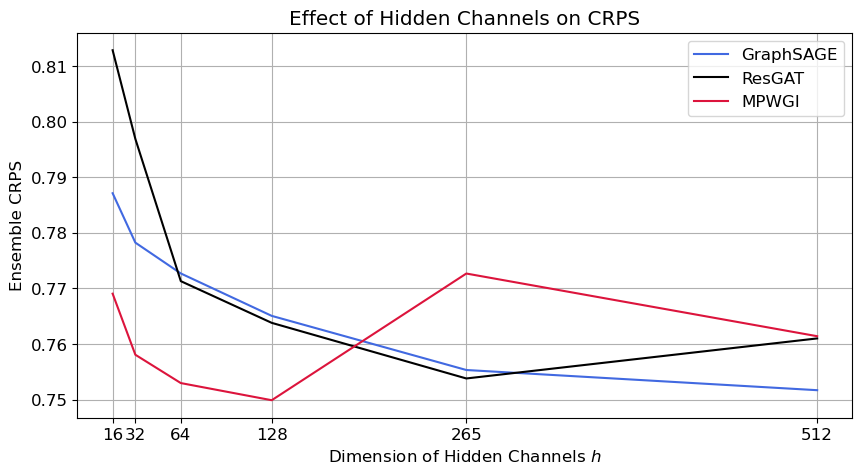

In [14]:
plt.rcParams.update({'font.size': 12})
variants = [int(f.split("/")[3]) for f in folders]
variable = folder.split("/")[2]

plt.figure(figsize=(10, 5))
plt.plot(variants, [s.item() for s in GraphSAGE_scores], color="royalblue", label="GraphSAGE")
plt.plot(variants, [s.item() for s in ResGAT_scores], color="black", label="ResGAT")
plt.plot(variants, [s.item() for s in MPWGI_scores], color="crimson", label="MPWGI")

# TODO customize these
plt.xticks(variants, variants)
plt.ylabel("Ensemble CRPS")
plt.xlabel("Dimension of Hidden Channels $h$")
plt.title("Effect of Hidden Channels on CRPS")

plt.legend()
plt.grid(True)
plt.savefig(f"plots/effect_of_{variable}.pdf", format='pdf', dpi=600, bbox_inches='tight')